importing essential libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

define dataset directory

In [2]:
data_dir = "/content/"

preprocess phase(import dataset files only,convert times and days and... to good form for training,convert categorical types to numerical,define lookback datas and targets,split data to training and test and validation sets)

In [3]:
train_x = []
label_scalers = {}
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(data_dir)): 
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    df = pd.read_csv(data_dir + file, parse_dates=[0])
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [8]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

define batch size for data loader

In [4]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

implement GRU and LSTM models as definition

In [5]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

training phase and validation phase implementation

In [6]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):

    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    epoch_times = []

    for epoch in range(1,EPOCHS+1):
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}->Step: {}/{}->Loss:{}".format(epoch, counter, len(train_loader), avg_loss/counter))
        print("Total loss of Epoch {}: {}".format(epoch, avg_loss/len(train_loader)))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

training of gru model

In [9]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Epoch 1->Step: 200/957->Loss:0.006595127508626319
Epoch 1->Step: 400/957->Loss:0.0036584198223863496
Epoch 1->Step: 600/957->Loss:0.002585865627139962
Epoch 1->Step: 800/957->Loss:0.0020238211358810077
Total loss of Epoch 1: 0.0017360321672092208
Epoch 2->Step: 200/957->Loss:0.0002440962934633717
Epoch 2->Step: 400/957->Loss:0.00022573266967810924
Epoch 2->Step: 600/957->Loss:0.00021805849927962603
Epoch 2->Step: 800/957->Loss:0.000209916765725211
Total loss of Epoch 2: 0.00020373185523048476
Epoch 3->Step: 200/957->Loss:0.0001684325710084522
Epoch 3->Step: 400/957->Loss:0.0001625738492475648
Epoch 3->Step: 600/957->Loss:0.00016063742824674895
Epoch 3->Step: 800/957->Loss:0.00015741885869829275
Total loss of Epoch 3: 0.00015405602091407577
Epoch 4->Step: 200/957->Loss:0.00014117030990746572
Epoch 4->Step: 400/957->Loss:0.00013999952452650177
Epoch 4->Step: 600/957->Loss:0.00013685821410035714
Epoch 4->Step: 800/957->Loss:0.00013452986723677896
Total loss of Epoch 4: 0.00013233017188371

training on lstm model

In [10]:
lstm_model = train(train_loader, lr, model_type="LSTM")

Epoch 1->Step: 200/957->Loss:0.009703759750118479
Epoch 1->Step: 400/957->Loss:0.005389839452545857
Epoch 1->Step: 600/957->Loss:0.0037853442163517078
Epoch 1->Step: 800/957->Loss:0.0029401929106461465
Total loss of Epoch 1: 0.0025103034121121835
Epoch 2->Step: 200/957->Loss:0.0002629104536754312
Epoch 2->Step: 400/957->Loss:0.0002495861876013805
Epoch 2->Step: 600/957->Loss:0.00023792092707784225
Epoch 2->Step: 800/957->Loss:0.00022900081999978285
Total loss of Epoch 2: 0.0002232372387684103
Epoch 3->Step: 200/957->Loss:0.0001814520583866397
Epoch 3->Step: 400/957->Loss:0.0001725716219516471
Epoch 3->Step: 600/957->Loss:0.00016891898989949064
Epoch 3->Step: 800/957->Loss:0.00016412728420618804
Total loss of Epoch 3: 0.00016292249031796518
Epoch 4->Step: 200/957->Loss:0.0001423116651494638
Epoch 4->Step: 400/957->Loss:0.00013984118264488644
Epoch 4->Step: 600/957->Loss:0.00013877452930804188
Epoch 4->Step: 800/957->Loss:0.00013503593614586863
Total loss of Epoch 4: 0.000134565240131847

evaluation gru model

In [11]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

sMAPE: 0.2580171390429557%


evaluation lstm model

In [12]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

sMAPE: 0.2453821563931586%


plot results

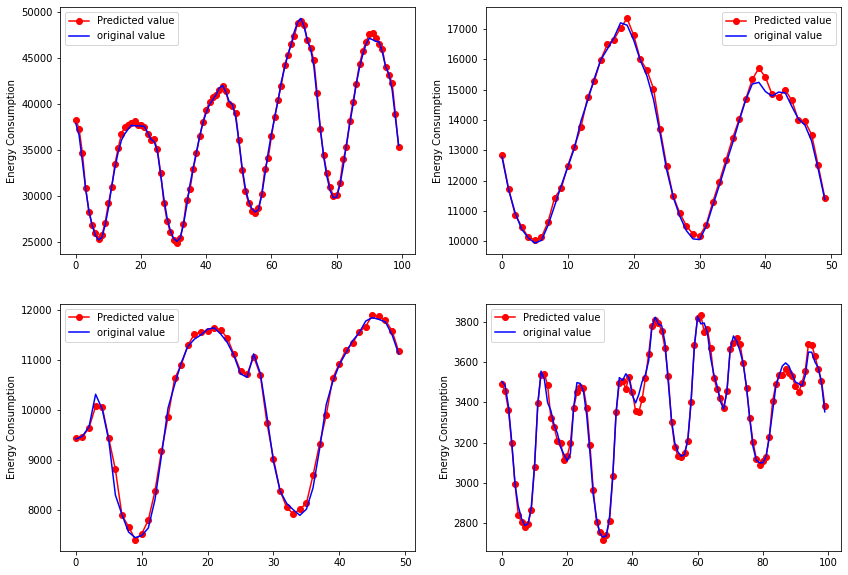

In [13]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="r", label="Predicted value")
plt.plot(targets[0][-100:], color="b", label="original value")
plt.ylabel('Energy Consumption')
plt.legend()
plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="r", label="Predicted value")
plt.plot(targets[8][-50:], color="b", label="original value")
plt.ylabel('Energy Consumption')
plt.legend()
plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="r", label="Predicted value")
plt.plot(targets[4][:50], color="b", label="original value")
plt.ylabel('Energy Consumption')
plt.legend()
plt.subplot(2,2,4)
plt.plot(lstm_outputs[6][:100], "-o", color="r", label="Predicted value")
plt.plot(targets[6][:100], color="b", label="original value")
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()